In [1]:
import swifttools.swift_too as swtoo
import os
from astropy.table import Table, vstack
import matplotlib.pyplot as plt
import numpy as np
import healpy as hp
from datetime import datetime, timedelta

ToDo:
- Getting failed trigger TTE data

In [12]:
# Set this to wherever you want to have all the data accumulate
DOWNLOAD_PATH = '/scratch/jjd330/swift_api_downloads/'

def utctime2met(utctime):
    '''
    Changes utc time to mission elapsed time in seconds (met)
    
    utctime: date time or string in Y-m-d H:M:S.f format should work
    '''
    
    cc = swtoo.Clock(utctime=utctime)
    
    return cc.met


def get_obsids(time, t_buff=100.0):
    
    if type(time) == str:
        time = datetime.strptime(time, '%Y-%m-%d %H:%M:%S.%f')
        
    start_time = time - timedelta(seconds=t_buff)
    end_time = time + timedelta(seconds=t_buff)
    print(start_time)
    print(end_time)
    
    oq = swtoo.ObsQuery(begin=start_time, length=timedelta(seconds=2*t_buff))
    print(oq)
    
    N = len(oq)
    
    obsids = []
    
    for i in range(N):
        
        if oq[i].begin < end_time and oq[i].end > start_time:
            
            obsids.append(oq[i].obsid)
            
    return obsids


def download_data(obsids, string_match=None, bat=True, auxil=True):
    
    down_results = []
    
    for obsid in obsids:
        res = swtoo.Swift_Data(obsid=obsid, bat=bat, auxil=auxil, match=string_match, outdir=DOWNLOAD_PATH)
        down_results.append(res)
        
    return down_results


def get_earth_sat_pos(sao_tab, met):
    '''
    Gets Earth RA, Dec, and occultation radius for Swift at a specific time
    
    input:
    sao_tab : Table of prefilter information (Earth pos, Sun pos, Sat position, etc.)
    met : mission elapsed time (s)

    
    output:
    RA : RA of Earth center for Swift 
    Dec : Dec of Earth center for Swift
    occultation_radius : radius of circle on sky that Earth occults for Swift (deg)
    '''
    
    sao_ind = np.argmin(np.abs(sao_tab['TIME'] - met))
    sao_row = sao_tab[sao_ind]
    
    altitude = sao_row['SAT_ALT']
    ra, dec = sao_row['EARTH_RA'], sao_row['EARTH_DEC']

    EARTH_RADIUS = 6378.140
    occultation_radius = np.rad2deg(np.arcsin(EARTH_RADIUS / altitude))

    return ra, dec, occultation_radius

def ang_sep(ra0, dec0, ra1, dec1):
    dcos = np.cos(np.radians(np.abs(ra0 - ra1)))
    angsep = np.arccos(
        np.cos(np.radians(90 - dec0)) * np.cos(np.radians(90 - dec1))
        + np.sin(np.radians(90 - dec0)) * np.sin(np.radians(90 - dec1)) * dcos
    )
    return np.rad2deg(angsep)


def is_pos_earth_occulted(ra, dec, sao_tab, met):
    '''
    Returns True if ra, dec is behind the Earth
    
    input:
    ra: RA of position of interest (scalar or array)
    dec: Dec of position of interest (scalar or array)
    sao_tab : Table of prefilter information (Earth pos, Sun pos, Sat position, etc.)
    met : mission elapsed time (s)

    
    output:
    Bool : True if ra, dec is behind Earth (same size as ra and dec)
    '''

    earth_ra, earth_dec, earth_rad = get_earth_sat_pos(sao_tab, met)
    
    angsep = ang_sep(ra, dec, earth_ra, earth_dec)
    
    return (angsep <= earth_rad)    
    
    
def is_circ_earth_occulted(ra, dec, radius, sao_tab, met):
    '''
    Returns fraction of circle by solid angle that is earth occulted
    0 if not Earth occulted at all
    
    input:
    ra: RA of circle center
    dec: Dec of circle center
    radius: radius of circle (deg)
    sao_tab : Table of prefilter information (Earth pos, Sun pos, Sat position, etc.)
    met : mission elapsed time (s)
    
    
    output:
    frac_occult : Fraction of the circle that is earth occulted (float)
    '''

    earth_ra, earth_dec, earth_rad = get_earth_sat_pos(sao_tab, met)
    
    nside = 2**7
    npix = hp.nside2npix(nside)
    
    earth_m = np.zeros(npix, dtype=int)
    earth_vec = hp.ang2vec(earth_ra, earth_dec, lonlat=True)
    earth_pix = hp.query_disc(nside, earth_vec, np.radians(earth_rad), nest=True)
    earth_m[earth_pix] = 1
    
    circ_m = np.zeros(hp.nside2npix(nside), dtype=int)
    vec = hp.ang2vec(ra, dec, lonlat=True)
    circ_pix = hp.query_disc(nside, vec, np.radians(radius), nest=True)
    circ_m[circ_pix] = 1
    
    frac_occult = np.sum(earth_m*circ_m) / np.sum(circ_m)

    return frac_occult
    
    
    
    
    
def get_pointing_direction(att_tab, met):
    '''
    Gets the boresight RA and Dec of Swift at a specific time
    
    input:
    att_tab : Table of attitude information
    met : mission elapsed time (s)

    
    output:
    RA : RA pnt direction
    Dec : Dec pnt direction
    '''

    
    att_ind = np.argmin(np.abs(att_tab['TIME'] - met))
    att_row = att_tab[att_ind]
    
    RA, DEC = att_row['POINTING'][0], att_row['POINTING'][1]
    
    return RA, DEC
    


def get_prefilter_data(time, t_buff=100.0):
    '''
    Finds all the observations in time - t_buff to time + t_buff
    downloads all the prefilter data tables and mergers them
    contains information like Earth position, satellite position, Sun position, etc.
    
    input:
    time : date time or string in Y-m-d H:M:S.f format should work
    t_buff : get data at time +/- t_buff seconds

    
    output:
    sao_tab : Table with prefilter information
    '''
    
    
    obsids = get_obsids(time, t_buff=t_buff)
    
    down_results = download_data(obsids, string_match=['*sao.fits.gz'])
    
    sao_tabs = []
    
    for down_result in down_results:

        sao_row = [r for r in down_result if 'sao' in r.filename][0]
        sao_fname = os.path.join(DOWNLOAD_PATH, sao_row.path, sao_row.filename)

        sao_tabs.append(Table.read(sao_fname))


    sao_tab = vstack(sao_tabs)
    
    return sao_tab



def get_pointing_data(time, t_buff=100.0):
    '''
    Finds all the observations in time - t_buff to time + t_buff
    downloads all the attitude data tables and mergers them
    
    input:
    time : date time or string in Y-m-d H:M:S.f format should work
    t_buff : get data at time +/- t_buff seconds

    
    output:
    att_tab : Table with pointing information
    '''
    
    
    obsids = get_obsids(time, t_buff=t_buff)
    
    down_results = download_data(obsids, string_match=['*pat.fits.gz'])
    
    att_tabs = []
    
    for down_result in down_results:

        att_row = [r for r in down_result if 'pat' in r.filename][0]
        att_fname = os.path.join(DOWNLOAD_PATH, att_row.path, att_row.filename)

        att_tabs.append(Table.read(att_fname))


    att_tab = vstack(att_tabs)
    
    return att_tab



def get_rates_data(time, t_buff=100.0):
    '''
    Finds all the observations in time - t_buff to time + t_buff
    downloads all the rate data tables and mergers them
    
    input:
    time : date time or string in Y-m-d H:M:S.f format should work
    t_buff : get data at time +/- t_buff seconds

    
    output:
    tab_ms : Table with the 64 ms rates data
    tab_quad : Table with the 1.6 s quad rates data
    tab_1s : Table with the 1 s rates data
    '''
    
    
    obsids = get_obsids(time, t_buff=t_buff)
    
    down_results = download_data(obsids, string_match=['*brt1s.lc.gz', '*brtqd.lc.gz', '*brtms.lc.gz'])
    
#     if len(down_results) > 1:

    tabs_1s = []
    tabs_quad = []
    tabs_ms = []

    for down_result in down_results:

        ms_row = [r for r in down_result if 'ms' in r.filename][0]
        ms_fname = os.path.join(DOWNLOAD_PATH, ms_row.path, ms_row.filename)

        tabs_ms.append(Table.read(ms_fname))


        s_row = [r for r in down_result if '1s' in r.filename][0]
        s_fname = os.path.join(DOWNLOAD_PATH, s_row.path, s_row.filename)

        tabs_1s.append(Table.read(s_fname))


        quad_row = [r for r in down_result if 'qd' in r.filename][0]
        quad_fname = os.path.join(DOWNLOAD_PATH, quad_row.path, quad_row.filename)

        tabs_quad.append(Table.read(quad_fname))

    tab_ms = vstack(tabs_ms)
    tab_1s = vstack(tabs_1s)
    tab_quad = vstack(tabs_quad)
    
    tab_ms.sort('TIME')
    tab_1s.sort('TIME')
    tab_quad.sort('TIME')
    
    return tab_ms, tab_quad, tab_1s

### A bunch of functions needed to do coordinate conversions 

These are all in NITRATES but I pasted them here to avoid you having to install it

In [3]:
align_mat = np.array(
    [
        [-1.96305411e-04, 6.56927099e-06, 9.99999981e-01],
        [9.99994245e-01, -3.38686178e-03, 1.96326534e-04],
        [3.38686300e-03, 9.99994265e-01, -5.90437390e-06],
    ]
)


def maintain_quat(q, round_off_err=1e-6):
    norm = np.sqrt(np.sum(np.square(q)))
    if (q[3] < 0) or (abs(norm - 1.0) > round_off_err):
        # print "fixing quat"
        invnorm = 1.0 / norm
        err = abs(norm - 1.0)
        if q[3] < 0:
            invnorm = -invnorm
        q = q * invnorm
    return q


def convertRotMatrixToQuat(rot):
    diag_sum = np.zeros(4)
    q = np.zeros(4)

    diag_sum[0] = 1 + rot[0][0] - rot[1][1] - rot[2][2]
    diag_sum[1] = 1 - rot[0][0] + rot[1][1] - rot[2][2]
    diag_sum[2] = 1 - rot[0][0] - rot[1][1] + rot[2][2]
    diag_sum[3] = 1 + rot[0][0] + rot[1][1] + rot[2][2]

    maxi = np.argmax(diag_sum)

    q[maxi] = 0.5 * np.sqrt(diag_sum[maxi])
    recip = 1.0 / (4.0 * q[maxi])

    if maxi == 0:
        q[1] = recip * (rot[0, 1] + rot[1, 0])
        q[2] = recip * (rot[2, 0] + rot[0, 2])
        q[3] = recip * (rot[1, 2] - rot[2, 1])

    elif maxi == 1:
        q[0] = recip * (rot[0, 1] + rot[1, 0])
        q[2] = recip * (rot[1, 2] + rot[2, 1])
        q[3] = recip * (rot[2, 0] - rot[0, 2])

    elif maxi == 2:
        q[0] = recip * (rot[2, 0] + rot[0, 2])
        q[1] = recip * (rot[1, 2] + rot[2, 1])
        q[3] = recip * (rot[0, 1] - rot[1, 0])

    elif maxi == 3:
        q[0] = recip * (rot[1, 2] - rot[2, 1])
        q[1] = recip * (rot[2, 0] - rot[0, 2])
        q[2] = recip * (rot[0, 1] - rot[1, 0])

    q = maintain_quat(q)

    return q


def convertQuatToRotMatrix(q):
    rot = np.zeros((3, 3))
    q2 = np.square(q)

    rot[0, 0] = q2[0] - q2[1] - q2[2] + q2[3]
    rot[1, 1] = -q2[0] + q2[1] - q2[2] + q2[3]
    rot[2, 2] = -q2[0] - q2[1] + q2[2] + q2[3]

    rot[0, 1] = 2.0 * (q[0] * q[1] + q[2] * q[3])
    rot[1, 0] = 2.0 * (q[0] * q[1] - q[2] * q[3])

    rot[0, 2] = 2.0 * (q[0] * q[2] - q[1] * q[3])
    rot[2, 0] = 2.0 * (q[0] * q[2] + q[1] * q[3])

    rot[1, 2] = 2.0 * (q[1] * q[2] + q[0] * q[3])
    rot[2, 1] = 2.0 * (q[1] * q[2] - q[0] * q[3])

    return rot


def invertQuat(q):
    q1 = -1.0 * q
    q1[3] *= -1

    return q1


def productOfQuats(q1, q2):
    q = np.zeros_like(q1)

    q[0] = q2[3] * q1[0] + q2[2] * q1[1] - q2[1] * q1[2] + q2[0] * q1[3]
    q[1] = -q2[2] * q1[0] + q2[3] * q1[1] + q2[0] * q1[2] + q2[1] * q1[3]
    q[2] = q2[1] * q1[0] - q2[0] * q1[1] + q2[3] * q1[2] + q2[2] * q1[3]
    q[3] = -q2[0] * q1[0] - q2[1] * q1[1] - q2[2] * q1[2] + q2[3] * q1[3]

    q = maintain_quat(q)

    return q


def applyRotMatrixToVector(rot, vec):
    newvec = np.zeros_like(vec)

    for i in range(len(newvec)):
        if vec.ndim > 1:
            newvec[i] = np.sum(vec * rot[i, :, np.newaxis], axis=0)
        else:
            newvec[i] = np.sum(vec * rot[i, :])

    return newvec


def radec2skyvec(ra, dec):
    z_sky = np.sin(np.radians(dec))
    x_sky = (np.cos(np.radians(dec))) * (np.cos(np.radians(ra)))
    y_sky = (np.cos(np.radians(dec))) * (np.sin(np.radians(ra)))
    skyunit = np.array([x_sky, y_sky, z_sky])
    return skyunit


def skyvec2radec(sky_vec):
    dec = np.rad2deg(np.arcsin(sky_vec[2]))
    ra = np.rad2deg(np.arctan2(sky_vec[1], sky_vec[0]))
    if np.isscalar(ra):
        if ra < 0:
            ra += 360.0
    else:
        if np.any(ra < 0):
            ra[(ra < 0)] += 360.0
    return ra, dec


def imxy2detvec(imx, imy):
    z = 1.0 / np.sqrt(imx**2.0 + imy**2.0 + 1.0)
    x = imx * z
    y = imy * z
    detunit = np.array([x, y, z])
    return detunit


def theta_phi2detvec(theta, phi):
    z = np.cos(np.radians(theta))
    x = np.sin(np.radians(theta)) * np.cos(np.radians(phi))
    y = np.sin(np.radians(theta)) * np.sin(np.radians(-phi))
    detunit = np.array([x, y, z])
    return detunit


def convertSkyToSensor(teldef_qinv, sky_vec, att_q):
    cor_q = productOfQuats(att_q, teldef_qinv)

    rot = convertQuatToRotMatrix(cor_q)

    det_vec = applyRotMatrixToVector(rot, sky_vec)

    return det_vec


def convertDetToSky(teldef_qinv, det_vec, att_q):
    cor_q = productOfQuats(att_q, teldef_qinv)

    cor_qinv = invertQuat(cor_q)

    rot = convertQuatToRotMatrix(cor_qinv)

    sky_vec = applyRotMatrixToVector(rot, det_vec)

    return sky_vec


def convert_radec2batxyz(ra, dec, att_q):
    """
    Converts ra, dec to the BAT x,y,z vector

    Parameters:
    ra: float in degrees
    dec: float in degrees
    att_q: the attitude quaternion (length 4 1D array)

    Returns:
    detector vec: length 3 float vector
    """
    teldef_q = convertRotMatrixToQuat(align_mat)
    teldef_qinv = invertQuat(teldef_q)
    att_q = maintain_quat(att_q)

    sky_vec = radec2skyvec(ra, dec)
    det_vec = convertSkyToSensor(teldef_qinv, sky_vec, att_q)

    return det_vec


def convert_radec2thetaphi(ra, dec, att_q):
    """
    Converts ra, dec to the BAT theta, phi

    Parameters:
    ra: float in degrees
    dec: float in degrees
    att_q: the attitude quaternion (length 4 1D array)

    Returns:
    theta, phi: float in degrees
    """
    teldef_q = convertRotMatrixToQuat(align_mat)
    teldef_qinv = invertQuat(teldef_q)
    att_q = maintain_quat(att_q)

    sky_vec = radec2skyvec(ra, dec)
    det_vec = convertSkyToSensor(teldef_qinv, sky_vec, att_q)

    theta = np.rad2deg(np.arccos(det_vec[2]))
    phi = np.rad2deg(np.arctan2(-det_vec[1], det_vec[0]))
    if np.isscalar(phi):
        if phi < 0.0:
            phi += 360.0
    else:
        bl = phi < 0.0
        if np.sum(bl) > 0:
            phi[bl] += 360.0

    return theta, phi


def convert_radec2imxy(ra, dec, att_q):
    """
    Converts ra, dec to imx, imy

    Parameters:
    ra: float in degrees
    dec: float in degrees
    att_q: the attitude quaternion (length 4 1D array)

    Returns:
    imx: float
    imy: float
    """
    teldef_q = convertRotMatrixToQuat(align_mat)
    teldef_qinv = invertQuat(teldef_q)
    att_q = maintain_quat(att_q)

    sky_vec = radec2skyvec(ra, dec)
    det_vec = convertSkyToSensor(teldef_qinv, sky_vec, att_q)

    imx = det_vec[0] / det_vec[2]
    imy = det_vec[1] / det_vec[2]
    return imx, imy


def convert_theta_phi2radec(theta, phi, att_q):
    """
    Converts theta, phi to ra, dec

    Parameters:
    theta: float in degrees
    phi: float in degrees
    att_q: the attitude quaternion (length 4 1D array)

    Returns:
    ra: float in degrees
    dec: float in degrees
    """

    teldef_q = convertRotMatrixToQuat(align_mat)
    teldef_qinv = invertQuat(teldef_q)
    att_q = maintain_quat(att_q)

    # det_vec = imxy2detvec(imx, imy)
    det_vec = theta_phi2detvec(theta, phi)

    sky_vec = convertDetToSky(teldef_qinv, det_vec, att_q)

    ra, dec = skyvec2radec(sky_vec)

    return ra, dec


def convert_imxy2radec(imx, imy, att_q):
    """
    Converts imx, imy to ra, dec

    Parameters:
    imx: float
    imy: float
    att_q: the attitude quaternion (length 4 1D array)

    Returns:
    ra: float in degrees
    dec: float in degrees
    """

    teldef_q = convertRotMatrixToQuat(align_mat)
    teldef_qinv = invertQuat(teldef_q)
    att_q = maintain_quat(att_q)

    det_vec = imxy2detvec(imx, imy)

    sky_vec = convertDetToSky(teldef_qinv, det_vec, att_q)

    ra, dec = skyvec2radec(sky_vec)

    return ra, dec


def theta_phi2imxy(theta, phi):
    imr = np.tan(np.radians(theta))
    imx = imr * np.cos(np.radians(phi))
    imy = imr * np.sin(np.radians(-phi))
    return imx, imy


def imxy2theta_phi(imx, imy):
    theta = np.rad2deg(np.arctan(np.sqrt(imx**2 + imy**2)))
    phi = np.rad2deg(np.arctan2(-imy, imx))
    if np.isscalar(phi):
        if phi < 0:
            phi += 360.0
    else:
        bl = phi < 0
        if np.sum(bl) > 0:
            phi[bl] += 360.0
    return theta, phi


def pnt2euler(ra, dec, roll, roll_sign=-1.0, roll_offset=0.0):
    phi = np.radians(ra)
    theta = np.radians(90.0 - dec)
    psi = np.radians(roll * roll_sign + 90.0 - roll_offset)

    return phi, theta, psi


def convertEulerToRotMatrix(phi, theta, psi):
    sphi = np.sin(phi)
    cphi = np.cos(phi)
    stheta = np.sin(theta)
    ctheta = np.cos(theta)
    spsi = np.sin(psi)
    cpsi = np.cos(psi)

    rot = np.zeros((3, 3))

    rot[0, 0] = cpsi * ctheta * cphi - spsi * sphi
    rot[0, 1] = cpsi * ctheta * sphi + spsi * cphi

    rot[1, 0] = -spsi * ctheta * cphi - cpsi * sphi
    rot[1, 1] = -spsi * ctheta * sphi + cpsi * cphi

    rot[0, 2] = -cpsi * stheta
    rot[1, 2] = spsi * stheta

    rot[2, 0] = stheta * cphi
    rot[2, 1] = stheta * sphi

    rot[2, 2] = ctheta

    return rot


def convertEulerToQuat(phi, theta, psi):
    rot = convertEulerToRotMatrix(phi, theta, psi)

    q = convertRotMatrixToQuat(rot)

    return q


def pnt2quat(ra, dec, roll):
    """
    Converts pointing direciton to a quaternion

    Parameters:
    ra: float in degrees
    dec: float in degrees
    roll: float in degrees

    Returns:
    q: the attitude quaternion (length 4 1D array)
    """

    teldef_q = convertRotMatrixToQuat(align_mat)

    phi, theta, psi = pnt2euler(ra, dec, roll)

    q_realigned = convertEulerToQuat(phi, theta, psi)

    q = productOfQuats(q_realigned, teldef_q)

    return q

### Functions to get BAT FoV

In [4]:
from astropy.wcs import WCS
from astropy.io import fits


def world2val(w, img, imxs, imys):
    '''
    Quick bi-linear interpolation of image
    '''
    #     pnts = np.vstack([imxs, imys]).T
    xinds, yinds = w.wcs_world2pix(imxs, imys, 0)
    int0_xinds = np.floor(xinds).astype(np.int64)
    int0_yinds = np.floor(yinds).astype(np.int64)
    if np.any(int0_xinds <= 0):
        int0_xinds[(int0_xinds <= 0)] = 0
    if np.any(int0_yinds <= 0):
        int0_yinds[(int0_yinds <= 0)] = 0
    if np.any(int0_xinds >= (img.shape[1] - 2)):
        int0_xinds[(int0_xinds >= (img.shape[1] - 2))] = img.shape[1] - 2
    if np.any(int0_yinds >= (img.shape[0] - 2)):
        int0_yinds[int0_yinds >= (img.shape[0] - 2)] = img.shape[0] - 2
    int1_xinds = int0_xinds + 1
    int1_yinds = int0_yinds + 1

    dx1inds = xinds - int0_xinds
    dy1inds = yinds - int0_yinds
    dx0inds = 1.0 - dx1inds
    dy0inds = 1.0 - dy1inds

    vals = (
        dx0inds * dy0inds * img[int0_yinds, int0_xinds]
        + dx1inds * dy0inds * img[int0_yinds, int1_xinds]
        + dx1inds * dy1inds * img[int1_yinds, int1_xinds]
        + dx0inds * dy1inds * img[int1_yinds, int0_xinds]
    )

    return vals



def get_pc_hpmap(pc_fname, att_row, Nside=2**7, nest=True):
    '''
    Returns healpix map with partial coding fraction in each pixel
    
    input:
    pc_fname: file name of partial coding file (string)
    att_row : row of attitude table (select by time you want)
    Nside: healpix nside to use in internal map calculation 
    
    
    output:
    pc_map : healpix map of partial coding fraction values (array)
    '''
    
    
    Npix = hp.nside2npix(Nside)
    pc_map = np.zeros(Npix)

    att_q = att_row["QPARAM"] # quaternion used for coordinate conversions
    pnt_ra, pnt_dec = att_row["POINTING"][:2]

    # max zenith angle still in FoV from boresight ~65 deg 
    vec = hp.ang2vec(pnt_ra, pnt_dec, lonlat=True)
    hp_inds = hp.query_disc(Nside, vec, np.radians(70.0), nest=nest)

    # get ra, dec of healpix map, then convert to image coords (imx, imy)
    hp_ras, hp_decs = hp.pix2ang(Nside, hp_inds, nest=nest, lonlat=True)
    hp_imxs, hp_imys = convert_radec2imxy(hp_ras, hp_decs, att_q)

    # max range of imy ~ -1 to 1
    # max range of imx ~ -1.9 to 1.9
    bl = (np.abs(hp_imys) < 1.01) & (np.abs(hp_imxs) < 2.0)

    # open pc file
    PC = fits.open(pc_fname)[0]
    w_t = WCS(PC.header, key="T")
    pc = PC.data

    # interpolate image onto healpix map
    pc_vals = world2val(w_t, pc, hp_imxs[bl], hp_imys[bl])
    pc_map[hp_inds[bl]] = pc_vals

    return pc_map


def get_fov_hpmap(pc_fname, att_row, Nside=2**7, pc_min=0.1):
    '''
    Returns healpix map that is True (or 1) for pixels in BAT FoV
    
    input:
    pc_fname: file name of partial coding file (string)
    att_row : row of attitude table (select by time you want)
    pc_min : min partial coding fraction to be considered in FoV (default 0.1)
    Nside: healpix nside to use in internal map calculation 
    
    output:
    fov_map : healpix map with True where the FoV is (array, bool)
    '''
    
    pc_map = get_pc_hpmap(pc_fname, att_row, Nside=Nside)
    
    fov_map = (pc_map >= pc_min)
    
    return fov_map


def is_radec_in_fov(ra, dec, pc_fname, att_row, pc_min=0.1, Nside=2**7):
    '''
    Returns True if RA, Dec is in BAT FoV
    
    input:
    ra: RA (deg)
    dec: Dec (deg)
    pc_fname: file name of partial coding file (string)
    att_row : row of attitude table (select by time you want)
    pc_min : min partial coding fraction to be considered in FoV (default 0.1)
    Nside: healpix nside to use in internal map calculation 
    
    output:
    bool : True if ra, dec is in FoV
    '''
    
    pix = hp.ang2pix(Nside, ra, dec, lonlat=True, nest=True)
    
    pc_map = get_pc_hpmap(pc_fname, att_row, Nside=Nside)
    
    return (pc_map[pix] >= pc_min)

    

def does_err_circ_overlap_fov(ra, dec, err_rad, pc_fname, att_row, pc_min=0.1, Nside=2**7):
    '''
    Returns fraction of error circle by solid angle that is in the BAT FoV
    0 if not in FoV at all
    
    input:
    ra: RA of circle center
    dec: Dec of circle center
    err_rad: radius of circle (deg)
    pc_fname: file name of partial coding file (string)
    att_row : row of attitude table (select by time you want)
    pc_min : min partial coding fraction to be considered in FoV (default 0.1)
    Nside: healpix nside to use in internal map calculation 
    
    output:
    frac : Fraction of the circle that is in BAT FoV (float)
    '''
    
    vec = hp.ang2vec(ra, dec, lonlat=True)
    hp_inds = hp.query_disc(Nside, vec, np.radians(err_rad), nest=True)
    
    pc_map = get_pc_hpmap(pc_fname, att_row, Nside=Nside)
    
    frac = np.sum(pc_map[hp_inds] >= pc_min) / len(hp_inds)
    
    return frac


def get_pc_at_pos(ra, dec, pc_fname, att_row, Nside=2**7):
    '''
    Returns True if RA, Dec is in BAT FoV
    
    input:
    ra: RA (deg)
    dec: Dec (deg)
    pc_fname: file name of partial coding file (string)
    att_row : row of attitude table (select by time you want)
    Nside: healpix nside to use in internal map calculation 
    
    output:
    bool : True if ra, dec is in FoV
    '''
    
    pix = hp.ang2pix(Nside, ra, dec, lonlat=True, nest=True)
    
    pc_map = get_pc_hpmap(pc_fname, att_row, Nside=Nside)
    
    return pc_map[pix]

### Give your trigger time as a string or datetime object

In [13]:
utc_str = '2015-02-28 04:57:23.00'

tab_ms, tab_quad, tab_1s = get_rates_data(utc_str)

2015-02-28 04:55:43
2015-02-28 04:59:03
+---------------------+---------------------+-------------+--------------------+--------------+--------------+
|          Begin Time |            End Time | Target Name | Observation Number | Exposure (s) | Slewtime (s) |
+---------------------+---------------------+-------------+--------------------+--------------+--------------+
| 2015-02-28 04:53:54 | 2015-02-28 05:00:16 |         N/A |        00632888000 |          320 |           62 |
+---------------------+---------------------+-------------+--------------------+--------------+--------------+


### Convert your time to mission elapsed time (met) to match the time format of the data

In [14]:
met = utctime2met(utc_str)
print(met)

446792256.245365


In [15]:
tab_1s.colnames

['TIME', 'COUNTS']

### 1 s binned rates data

Text(0, 0.5, 'Count Rate')

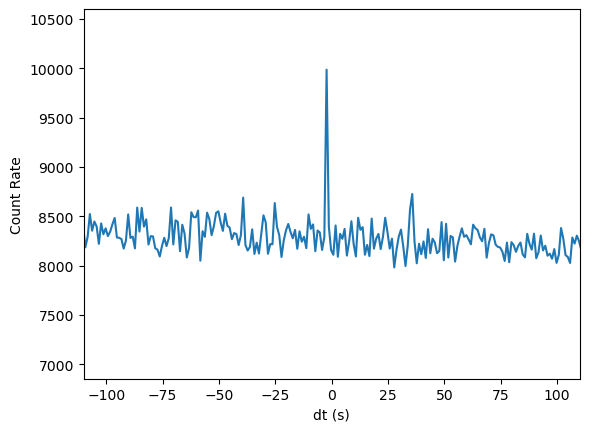

In [16]:
plt.plot(tab_1s['TIME'] - met, tab_1s['COUNTS'])

plt.xlim(-110, 110)

plt.xlabel('dt (s)')
plt.ylabel('Count Rate')

In [17]:
tab_ms.colnames

['TIME', 'COUNTS']

### 64 ms binned rates data in 4 energy bins

Text(0.5, 0, 'dt (s)')

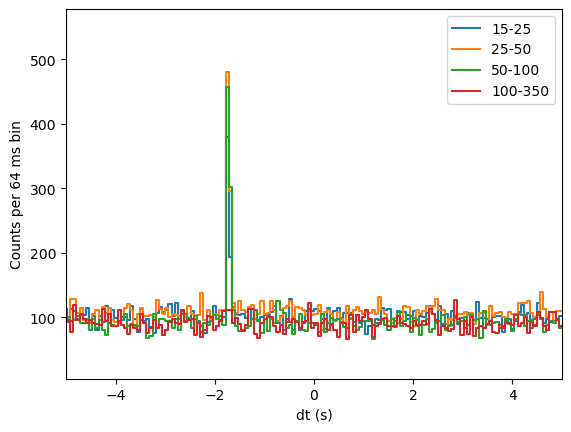

In [18]:
plt.step(tab_ms['TIME'] - met, tab_ms['COUNTS'], label=['15-25', '25-50', '50-100', '100-350'])

plt.xlim(-5, 5)
plt.legend()

plt.ylabel('Counts per 64 ms bin')
plt.xlabel('dt (s)')

### 64 ms binned rates data summed into 1 energy bin

Text(0.5, 0, 'dt (s)')

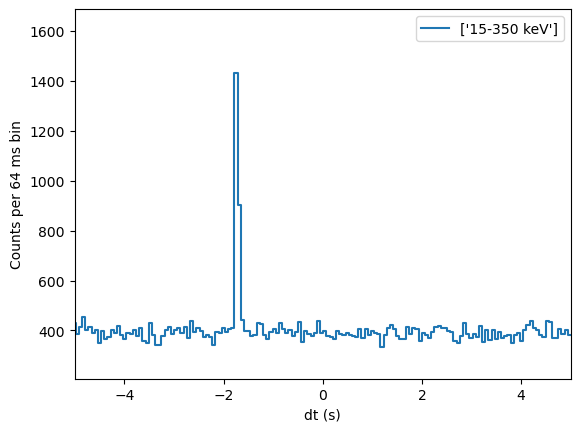

In [19]:
plt.step(tab_ms['TIME'] - met, np.sum(tab_ms['COUNTS'],axis=1), label=['15-350 keV'])

plt.xlim(-5, 5)
plt.legend()

plt.ylabel('Counts per 64 ms bin')
plt.xlabel('dt (s)')

### Getting pointing information (attitude file)

In [20]:
att_tab = get_pointing_data(utc_str)

2015-02-28 04:55:43
2015-02-28 04:59:03
+---------------------+---------------------+-------------+--------------------+--------------+--------------+
|          Begin Time |            End Time | Target Name | Observation Number | Exposure (s) | Slewtime (s) |
+---------------------+---------------------+-------------+--------------------+--------------+--------------+
| 2015-02-28 04:53:54 | 2015-02-28 05:00:16 |         N/A |        00632888000 |          320 |           62 |
+---------------------+---------------------+-------------+--------------------+--------------+--------------+


Text(0, 0.5, 'RA/Dec (deg)')

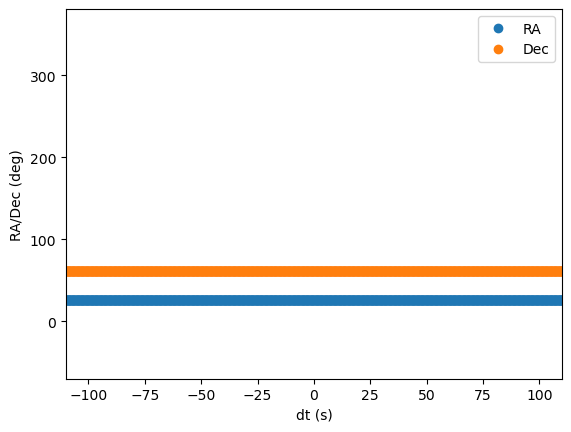

In [21]:
plt.plot(att_tab['TIME'] - met, att_tab['POINTING'][:,:2], 'o', label=['RA', 'Dec'])

plt.xlim(-110, 110)
plt.legend()
plt.xlabel('dt (s)')
plt.ylabel('RA/Dec (deg)')

### grabbing the pointing direction at a particular time 

In [22]:
ra_pnt, dec_pnt = get_pointing_direction(att_tab, met)
print(ra_pnt, dec_pnt)

26.611099789872938 61.78158632361296


### Getting file with Earth position 
Also has info about satellite position, Sun position, and more

In [23]:
sao_tab = get_prefilter_data(utc_str)

2015-02-28 04:55:43
2015-02-28 04:59:03
+---------------------+---------------------+-------------+--------------------+--------------+--------------+
|          Begin Time |            End Time | Target Name | Observation Number | Exposure (s) | Slewtime (s) |
+---------------------+---------------------+-------------+--------------------+--------------+--------------+
| 2015-02-28 04:53:54 | 2015-02-28 05:00:16 |         N/A |        00632888000 |          320 |           62 |
+---------------------+---------------------+-------------+--------------------+--------------+--------------+


In [24]:
sao_tab.colnames

['TIME',
 'POSITION',
 'VELOCITY',
 'QUATERNION',
 'PNTUNIT',
 'POLAR',
 'RA',
 'DEC',
 'ROLL',
 'SAT_LAT',
 'SAT_LON',
 'SAT_ALT',
 'ELV',
 'BR_EARTH',
 'SUNSHINE',
 'FOV_FLAG',
 'SUN_ANGLE',
 'MOON_ANGLE',
 'RAM_ANGLE',
 'ANG_DIST',
 'SAA',
 'SAA_TIME',
 'COR_ASCA',
 'COR_SAX',
 'MCILWAIN_L',
 'SUN_RA',
 'SUN_DEC',
 'MOON_RA',
 'MOON_DEC',
 'EARTH_RA',
 'EARTH_DEC']

### Grabbing the RA, Dec of Earth center and its radius on the sky for Swift

In [25]:
earth_ra, earth_dec, earth_radius = get_earth_sat_pos(sao_tab, met)
print(earth_ra, earth_dec, earth_radius)

256.34 6.6380024 66.70298150096666


### Just returning a True or False if a specific position is behind the Earth

In [27]:
gbm_ra, gbm_dec = 14.04, 32.92

print(is_pos_earth_occulted(gbm_ra, gbm_dec, sao_tab, met))

False


### Calculating the fraction of an error circle's solid angle that is behind the Earth

In [28]:
err_rad = 10.0 # deg
print(is_circ_earth_occulted(gbm_ra, gbm_dec, err_rad, sao_tab, met))

err_rad = 50.0 # deg
print(is_circ_earth_occulted(gbm_ra, gbm_dec, 50.0, sao_tab, met))

0.0
0.035256592811983824


# BAT FoV Stuff

This uses a random partial coding map and rotates it to the pointing direction requested. The partial coding map changes with which detectors are active, so this is not 100% accurate but is a good approximation. 

### Find if position is in BAT FoV

In [29]:
pc_fname = 'fov_BAT_pc.img'
att_ind = np.argmin(np.abs(att_tab['TIME'] - met))
att_row = att_tab[att_ind]

is_radec_in_fov(gbm_ra, gbm_dec, pc_fname, att_row)

True

### Calculating the fraction of an error circle's solid angle that is in BAT's FoV

In [30]:
err_rad = 10.0 # deg
print( does_err_circ_overlap_fov(gbm_ra, gbm_dec, err_rad, pc_fname, att_row) )

err_rad = 50.0 # deg
print( does_err_circ_overlap_fov(gbm_ra, gbm_dec, err_rad, pc_fname, att_row) )

1.0
0.6200091131742325


### Get FoV healpix map

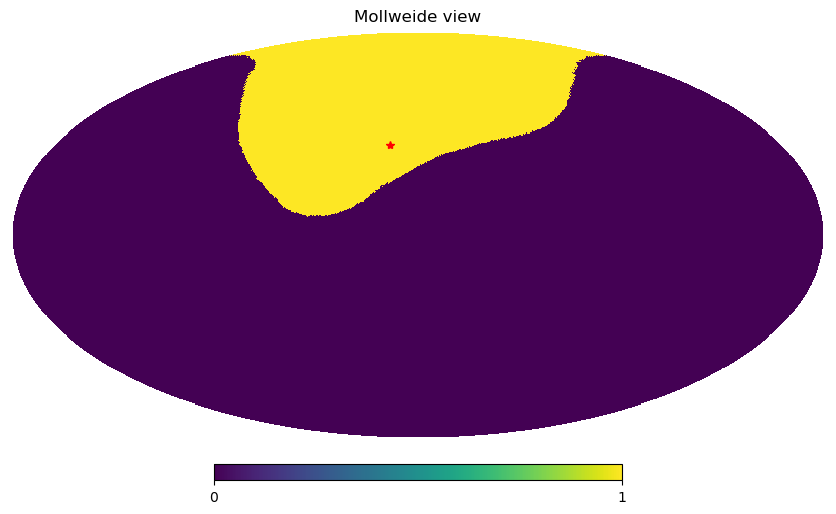

In [33]:
fov_map = get_fov_hpmap(pc_fname, att_row)

hp.mollview(fov_map, nest=True)
hp.projplot(gbm_ra, gbm_dec, 'r*', lonlat=True)

### Get partial coding healpix map

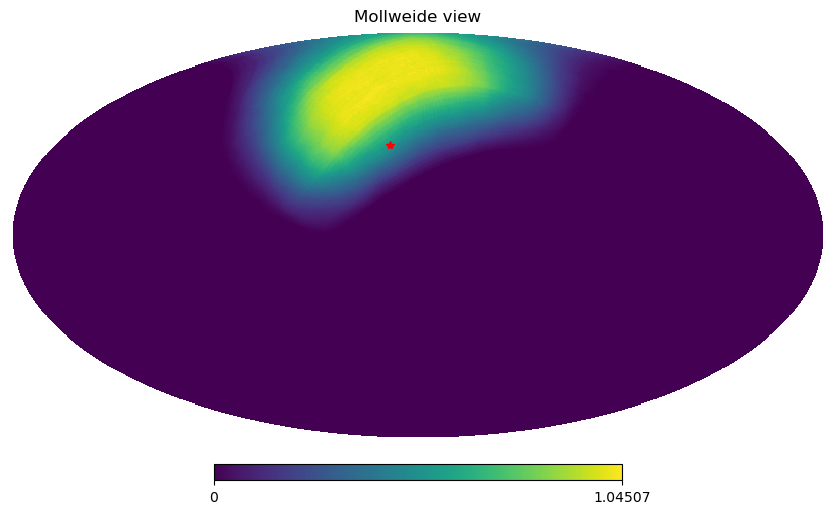

In [32]:
pc_map = get_pc_hpmap(pc_fname, att_row)

hp.mollview(pc_map, nest=True)
hp.projplot(gbm_ra, gbm_dec, 'r*', lonlat=True)

In [34]:
get_pc_at_pos(gbm_ra, gbm_dec, pc_fname, att_row)

0.5523040983559131